In [1]:
pip install category_encoders

You should consider upgrading via the 'c:\Users\swhon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install xgboost

You should consider upgrading via the 'c:\Users\swhon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import WOEEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.utils import resample
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sns.set_style('whitegrid') 
sns.set_palette('pastel')  

import warnings
warnings.simplefilter("ignore")

In [4]:
train_df = pd.read_csv('fraudTrain.csv', index_col='Unnamed: 0')
test_df = pd.read_csv('fraudTest.csv', index_col='Unnamed: 0')

# Step1. Exploratory Data Analysis 

In [5]:
train_df.head(3)
train_df.info()
train_df.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

(1296675, 22)

In [6]:
is_fraud = train_df["is_fraud"].value_counts()
print("Yes: ",is_fraud[1])
print("No: ",is_fraud[0])

Yes:  7506
No:  1289169


In [7]:
print(train_df.isna().sum().sum())
print(train_df.duplicated().sum())

0
0


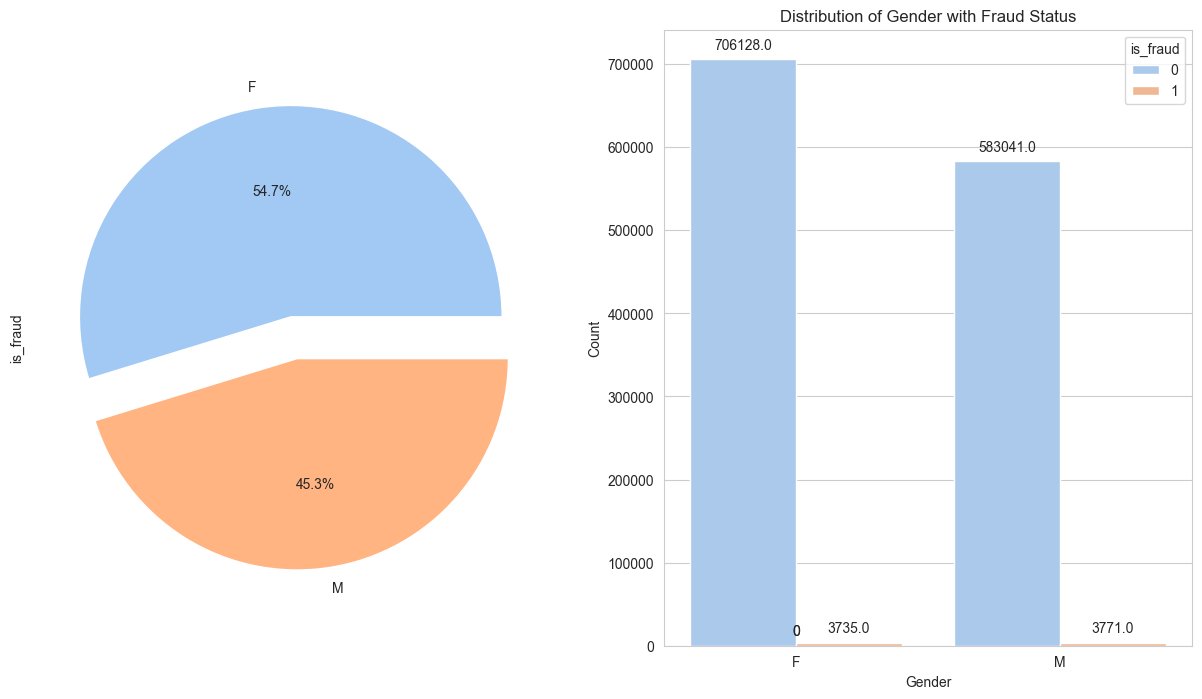

In [8]:
fig,axb = plt.subplots(ncols=2,nrows=1,figsize=(15, 8))

#Gender Distribution
explode = [0.1, 0.1]
train_df.groupby('gender')['is_fraud'].count().plot.pie(explode=explode, autopct="%1.1f%%",ax=axb[0]);

ax = sns.countplot(x="gender", hue="is_fraud", data=train_df,ax=axb[1])

# Add values on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Set labels and title
plt.title("Distribution of Gender with Fraud Status")
plt.xlabel("Gender")
plt.ylabel("Count")

# Show the plot
plt.show()

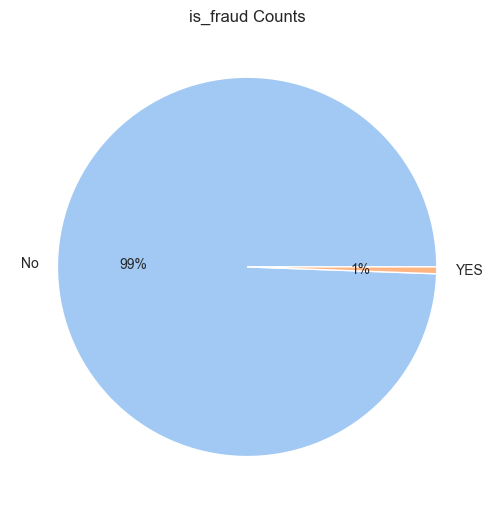

In [9]:
is_fraud = train_df["is_fraud"].value_counts()
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # Subplot for the pie chart
plt.pie(is_fraud, labels=["No", "YES"], autopct="%0.0f%%")
plt.title("is_fraud Counts")
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [10]:
train_df['trans_date_trans_time'] = pd.to_datetime(train_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')
test_df['trans_date_trans_time'] = pd.to_datetime(test_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

In [11]:
train_df['hour'] = train_df['trans_date_trans_time'].dt.hour
test_df['hour'] = test_df['trans_date_trans_time'].dt.hour

train_df['month'] = train_df['trans_date_trans_time'].dt.month
test_df['month'] = test_df['trans_date_trans_time'].dt.month

train_df.head()

trans_date_trans_time            cc_num                            merchant  \
0   2019-01-01 00:00:18  2703186189652095          fraud_Rippin, Kub and Mann   
1   2019-01-01 00:00:44      630423337322     fraud_Heller, Gutmann and Zieme   
2   2019-01-01 00:00:51    38859492057661                fraud_Lind-Buckridge   
3   2019-01-01 00:01:16  3534093764340240  fraud_Kutch, Hermiston and Farrell   
4   2019-01-01 00:03:06   375534208663984                 fraud_Keeling-Crist   

        category     amt      first     last gender  \
0       misc_net    4.97   Jennifer    Banks      F   
1    grocery_pos  107.23  Stephanie     Gill      F   
2  entertainment  220.11     Edward  Sanchez      M   
3  gas_transport   45.00     Jeremy    White      M   
4       misc_pos   41.96      Tyler   Garcia      M   

                         street            city  ... city_pop  \
0                561 Perry Cove  Moravian Falls  ...     3495   
1  43039 Riley Greens Suite 393          Orient  ...      149   
2      594 White Dale Suite 530      Malad City  ...     4154   
3   9443 Cynthia Court Apt. 038         Boulder  ...     1939   
4              408 Bradley Rest        Doe Hill  ...       99   

                                 job         dob  \
0          Psychologist, counselling  1988-03-09   
1  Special educational needs teacher  1978-06-21   
2        Nature conservation officer  1962-01-19   
3                    Patent attorney  1967-01-12   
4     Dance movement psychotherapist  1986-03-28   

                          trans_num   unix_time  merch_lat  merch_long  \
0  0b242abb623afc578575680df30655b9  1325376018  36.011293  -82.048315   
1  1f76529f8574734946361c461b024d99  1325376044  49.159047 -118.186462   
2  a1a22d70485983eac12b5b88dad1cf95  1325376051  43.150704 -112.154481   
3  6b849c168bdad6f867558c3793159a81  1325376076  47.034331 -112.561071   
4  a41d7549acf90789359a9aa5346dcb46  1325376186  38.674999  -78.632459   

  is_fraud  hour  month  
0        0     0      1  
1        0     0      1  
2        0     0      1  
3        0     0      1  
4        0     0      1  

[5 rows x 24 columns]

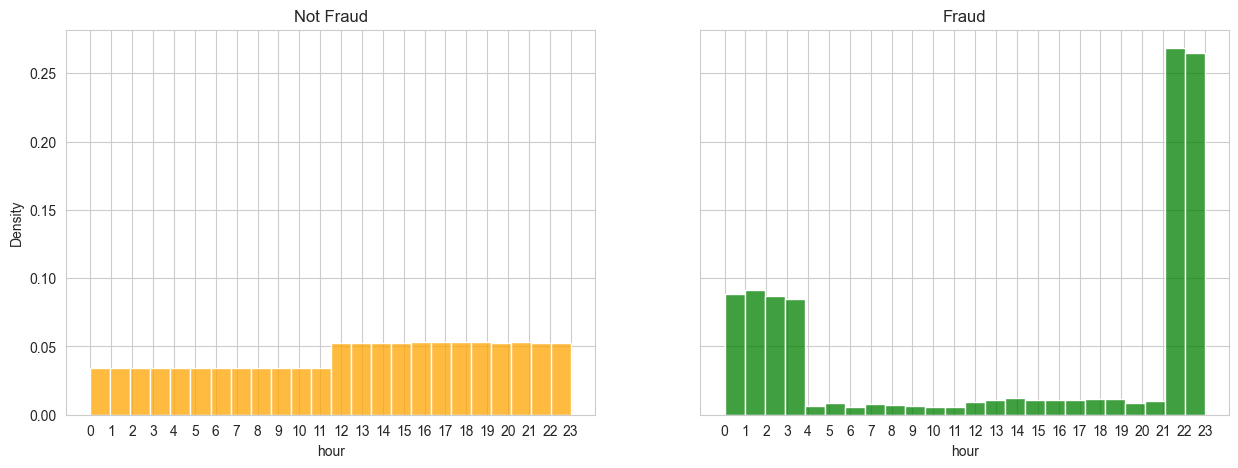

In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=True)

ax1 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 0],
                   stat="density", bins=24, ax=ax1, color="orange")

ax2 = sns.histplot(x='hour', data=train_df[train_df["is_fraud"] == 1],
                   stat="density", bins=24, ax=ax2, color="green")

ax1.set_title("Not Fraud")
ax2.set_title("Fraud")

ax1.set_xticks(np.arange(24)) # ticks of the day 0 -> 23
ax2.set_xticks(np.arange(24));

------

# Step2. Pre-Processing

In [13]:
unique_transaction_count = len(train_df['trans_num'].unique())
print("Total count of unique transaction numbers:", unique_transaction_count)

Total count of unique transaction numbers: 1296675


In [14]:
# remove non-useful columns
columns_to_drop = ['first', 'unix_time', 'dob', 'cc_num', 'zip', 'city','street', 'state', 'trans_num', 'trans_date_trans_time']
train_df = train_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)
train_df.head(2)

merchant     category     amt   last gender  \
0       fraud_Rippin, Kub and Mann     misc_net    4.97  Banks      F   
1  fraud_Heller, Gutmann and Zieme  grocery_pos  107.23   Gill      F   

       lat      long  city_pop                                job  merch_lat  \
0  36.0788  -81.1781      3495          Psychologist, counselling  36.011293   
1  48.8878 -118.2105       149  Special educational needs teacher  49.159047   

   merch_long  is_fraud  hour  month  
0  -82.048315         0     0      1  
1 -118.186462         0     0      1

In [15]:
train_df['merchant'] = train_df['merchant'].apply(lambda x : x.replace('fraud_',''))

In [80]:
test_df['merchant'] = test_df['merchant'].apply(lambda x : x.replace('fraud_',''))

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296675 entries, 0 to 1296674
Data columns (total 14 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   merchant    1296675 non-null  object 
 1   category    1296675 non-null  object 
 2   amt         1296675 non-null  float64
 3   last        1296675 non-null  object 
 4   gender      1296675 non-null  object 
 5   lat         1296675 non-null  float64
 6   long        1296675 non-null  float64
 7   city_pop    1296675 non-null  int64  
 8   job         1296675 non-null  object 
 9   merch_lat   1296675 non-null  float64
 10  merch_long  1296675 non-null  float64
 11  is_fraud    1296675 non-null  int64  
 12  hour        1296675 non-null  int64  
 13  month       1296675 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 148.4+ MB


In [81]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 555719 entries, 0 to 555718
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   merchant    555719 non-null  object 
 1   category    555719 non-null  object 
 2   amt         555719 non-null  float64
 3   last        555719 non-null  object 
 4   gender      555719 non-null  object 
 5   lat         555719 non-null  float64
 6   long        555719 non-null  float64
 7   city_pop    555719 non-null  int64  
 8   job         555719 non-null  object 
 9   merch_lat   555719 non-null  float64
 10  merch_long  555719 non-null  float64
 11  is_fraud    555719 non-null  int64  
 12  hour        555719 non-null  int64  
 13  month       555719 non-null  int64  
dtypes: float64(5), int64(4), object(5)
memory usage: 63.6+ MB


------

# Step3. Encoding

In [17]:
# applying label encoding
train_df['gender'] = train_df['gender'].map({'F': 0, 'M': 1})

# applying WOE encoding
for col in ['job','merchant', 'category', 'lat', 'last']:
    train_df[col] = WOEEncoder().fit_transform(train_df[col],train_df['is_fraud'])

In [82]:
# applying label encoding
test_df['gender'] = test_df['gender'].map({'F': 0, 'M': 1})

# applying WOE encoding
for col in ['job','merchant', 'category', 'lat', 'last']:
    test_df[col] = WOEEncoder().fit_transform(test_df[col],test_df['is_fraud'])

------

# Step4. Over-Sampling and Scaling

In [83]:
X=train_df.drop("is_fraud",axis=1)
y=train_df['is_fraud']

# train and validation dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=65)

X_test=test_df.drop("is_fraud",axis=1)
y_test=test_df['is_fraud']


In [84]:
No_class = y_train[y_train==0]
yes_class = y_train[y_train==1]

In [85]:
print(len(No_class))
print(len(yes_class))

1031335
6005


In [86]:
!pip install -U imbalanced-learn

You should consider upgrading via the 'C:\Users\swhon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [87]:
from imblearn.over_sampling import SMOTE

In [88]:
smote = SMOTE(random_state=65)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [97]:
print(sum(y_train_smote== 0))
print(sum(y_train_smote== 1))

1031335
1031335


In [90]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_smote)

X_val = scaler.transform(X_val)
X_test=scaler.transform(X_test)

------

In [92]:
len(X_train)

2062670

# Step5. Machine Learning model training

## 1. Logistic Regression -> LR

In [101]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train_smote)
predict_LR = LR_model.predict(X_test)

print(classification_report(y_test, predict_LR))
LR_accuracy = accuracy_score(predict_LR,y_test)
print('Logistic Regression accuracy is: {:.2f}%'.format(LR_accuracy*100))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93    553574
           1       0.03      0.92      0.05      2145

    accuracy                           0.86    555719
   macro avg       0.51      0.89      0.49    555719
weighted avg       1.00      0.86      0.92    555719

Logistic Regression accuracy is: 86.30%


## 2. Support Vector Machine Model (SVC)

In [21]:
svm_model = LinearSVC()
svm_model.fit(X_train, y_train_smote)
predict = svm_model.predict(X_test)

print(classification_report(y_test, predict))
svm_accuracy = accuracy_score(predict,y_test)
print('SVC model accuracy is: {:.2f}%'.format(svm_accuracy*100))


              precision    recall  f1-score   support

           0       0.78      0.94      0.85      1486
           1       0.93      0.74      0.82      1517

    accuracy                           0.84      3003
   macro avg       0.85      0.84      0.84      3003
weighted avg       0.85      0.84      0.84      3003

SVC model accuracy is: 83.92%


## 3. Gaussian Naive Bayes model

In [102]:
# Create and train the Gaussian Naive Bayes model
NB_model = GaussianNB()
NB_model.fit(X_train, y_train_smote)

# Make predictions on the test set
y_pred_naive = NB_model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred_naive))
GaussianNB_accuracy = accuracy_score(y_pred_naive, y_test)
print('Naive Bayes model accuracy is: {:.2f}%'.format(GaussianNB_accuracy * 100))

              precision    recall  f1-score   support

           0       1.00      0.86      0.93    553574
           1       0.02      0.78      0.04      2145

    accuracy                           0.86    555719
   macro avg       0.51      0.82      0.48    555719
weighted avg       1.00      0.86      0.92    555719

Naive Bayes model accuracy is: 86.37%


## 4. Decision Tree Model (ID3)

In [105]:
DT = DecisionTreeClassifier(max_depth=(1), random_state=0)
DT.fit(X_train, y_train_smote)
predict_ID3 = DT.predict(X_test)
print(classification_report(y_test, predict_ID3))
ID3_accuracy = accuracy_score(predict_ID3,y_test)
print('ID3 model accuracy is: {:.2f}%'.format(ID3_accuracy*100))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99    553574
           1       0.10      0.74      0.17      2145

    accuracy                           0.97    555719
   macro avg       0.55      0.86      0.58    555719
weighted avg       1.00      0.97      0.98    555719

ID3 model accuracy is: 97.19%


## 5. RandomForestClassifier

In [104]:
# Initialize and train the Random Forest classifier
RF = RandomForestClassifier(n_estimators=100, random_state=0)
RF.fit(X_train, y_train_smote)

predict_RF = RF.predict(X_test)

# Evaluate the model
print(classification_report(y_test, predict_RF))
RF_accuracy = accuracy_score(predict_RF, y_test)
print('Random Forest model accuracy is: {:.2f}%'.format(RF_accuracy * 100))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94    553574
           1       0.03      0.88      0.06      2145

    accuracy                           0.89    555719
   macro avg       0.51      0.88      0.50    555719
weighted avg       1.00      0.89      0.94    555719

Random Forest model accuracy is: 88.95%


In [106]:
Algorithms = ['RandomForest', 'Decision Tree', 'Logistic Regression', 'Support Vector Machine', 'Gaussian Naive Bayes']
accuracy = [RF_accuracy, ID3_accuracy, LR_accuracy, svm_accuracy, GaussianNB_accuracy]

FinalResult=pd.DataFrame({'Algorithm':Algorithms, 'Accuracy':accuracy})
FinalResult

Algorithm  Accuracy
0            RandomForest  0.889480
1           Decision Tree  0.971944
2     Logistic Regression  0.863048
3  Support Vector Machine  0.839161
4    Gaussian Naive Bayes  0.863719

In [107]:
import joblib

In [108]:
joblib.dump(RF, 'random_forest_model.joblib')

['random_forest_model.joblib']

# FastAPI

In [109]:
!pip install fastapi
!pip install uvicorn
!pip install pydantic

You should consider upgrading via the 'C:\Users\swhon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\swhon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\swhon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [110]:
from fastapi import FastAPI
from pydantic import BaseModel
import uvicorn
import nest_asyncio

from typing import Union

In [111]:
model=joblib.load("random_forest_model.joblib")

In [112]:
nest_asyncio.apply()

In [116]:
train_df

merchant  category     amt      last  gender      lat      long  \
0        0.959326  0.924914    4.97 -2.469513       0  36.0788  -81.1781   
1        0.663187  0.898799  107.23 -0.673638       0  48.8878 -118.2105   
2       -0.790166 -0.847622  220.11  0.433257       1  42.1808 -112.2620   
3       -0.416817 -0.209382   45.00  0.148996       1  46.2306 -112.1138   
4       -0.277905 -0.611091   41.96  0.423436       1  38.4207  -79.4629   
...           ...       ...     ...       ...     ...      ...       ...   
1296670 -0.613642 -0.847622   15.56 -0.195618       1  37.7175 -112.4777   
1296671 -0.711004 -1.252360   51.70  0.148996       1  39.2667  -77.5101   
1296672 -1.279624 -1.252360  105.93  0.132409       1  32.9396 -105.8189   
1296673 -0.798063 -1.252360   74.90 -0.646510       1  43.3526 -102.5411   
1296674 -0.955654 -1.252360    4.30 -0.168538       1  45.8433 -113.8748   

         city_pop       job  merch_lat  merch_long  is_fraud  hour  month  
0            3495 -1.080186  36.011293  -82.048315         0     0      1  
1             149 -0.904144  49.159047 -118.186462         0     0      1  
2            4154  1.120434  43.150704 -112.154481         0     0      1  
3            1939  0.361872  47.034331 -112.561071         0     0      1  
4              99 -2.464077  38.674999  -78.632459         0     0      1  
...           ...       ...        ...         ...       ...   ...    ...  
1296670       258 -0.049141  36.841266 -111.690765         0    12      6  
1296671       100  1.081518  38.906881  -78.246528         0    12      6  
1296672       899  0.071538  33.619513 -105.130529         0    12      6  
1296673      1126 -0.266356  42.788940 -103.241160         0    12      6  
1296674       218  0.261788  46.565983 -114.186110         0    12      6  

[1296675 rows x 14 columns]

Version 1

In [117]:
from fastapi import FastAPI
from pydantic import BaseModel
from typing import Union
import joblib
import numpy as np

# 모델 로드
model = joblib.load("random_forest_model.joblib")

api_title = "CreditCardFraudDetectionApp"
api_description = """
CreditCardFraudDetectionApp allows you to predict if a transaction is fraudulent or not.
"""

app = FastAPI(title=api_title, description=api_description)

class TransactionInput(BaseModel):
    amt: float
    category: str
    merch_lat: float
    merch_long: float

class PredictOutput(BaseModel):
    is_fraud: bool
    probability: float

@app.get("/")
def root():
    return "Hello! This is the credit card fraud prediction ML service!"

@app.post("/predict/", response_model=PredictOutput)
def predict_fraud(transaction: TransactionInput):
    features = np.array([[transaction.amt, transaction.merch_lat, transaction.merch_long]])
    prediction = model.predict(features)
    probability = model.predict_proba(features)[:, 1][0]

    return PredictOutput(is_fraud=bool(prediction[0]), probability=float(probability))

@app.get("/transactions/{transaction_id}")
def read_transaction(transaction_id: int, q: Union[str, None] = None):
    return {"transaction_id": transaction_id, "q": q}

@app.put("/transactions/{transaction_id}")
def update_transaction(transaction_id: int, transaction: TransactionInput):
    return {"transaction_amt": transaction.amt, "transaction_id": transaction_id}


Version 2

In [39]:
# api_title="CreditCardFraudDetectionApp"
# api_description="""
# CreditCardFraudDetectionApp allows you to predict if a transaction is fraudulent or not.
# """

# app=FastAPI(title=api_title,description=api_description)

# class TransactionInput(BaseModel):
#     amt: float
#     category: str
#     merch_lat: float
#     merch_long: float

# class PredictOutput(BaseModel):
#     is_fraud: Union[bool, None] = None
#     probability: Union[float, None] = None

# @app.get("/") # sending the data 
# def root():
#     return "Hello! This is the credit card fraud prediction ML service!"

# @app.post("/predict/",response_model=PredictOutput)
# def predict_fraud(transaction:TransactionInput)->bool:
#     features=np.array([[transaction.amt, transaction.category,transaction.merch_lat,transaction.merch_long]])
#     prediction=model.predict(features)
#     is_fraud=bool(prediction[0])
#     response_data={
#         "is_fraud": is_fraud,
#         "message": "This transaction is likely to be fraudulent" if is_fraud else "This transaction is not likely to be fraudulent"
#     }
#     return response_data

In [114]:
!pip install nest_asyncio

You should consider upgrading via the 'C:\Users\swhon\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [118]:
import asyncio

async def run_server():
    await uvicorn.run(app, host="127.0.0.1", port=8000)

await run_server()

INFO:     Started server process [19832]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:57009 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:57014 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:57014 - "GET /openapi.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:57022 - "POST /predict/ HTTP/1.1" 422 Unprocessable Entity
INFO:     127.0.0.1:57048 - "POST /predict/ HTTP/1.1" 422 Unprocessable Entity
INFO:     127.0.0.1:57060 - "POST /predict/ HTTP/1.1" 500 Internal Server Error


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "c:\Users\swhon\AppData\Local\Programs\Python\Python39\lib\site-packages\uvicorn\protocols\http\httptools_impl.py", line 411, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
  File "c:\Users\swhon\AppData\Local\Programs\Python\Python39\lib\site-packages\uvicorn\middleware\proxy_headers.py", line 69, in __call__
    return await self.app(scope, receive, send)
  File "c:\Users\swhon\AppData\Local\Programs\Python\Python39\lib\site-packages\fastapi\applications.py", line 1054, in __call__
    await super().__call__(scope, receive, send)
  File "c:\Users\swhon\AppData\Local\Programs\Python\Python39\lib\site-packages\starlette\applications.py", line 123, in __call__
    await self.middleware_stack(scope, receive, send)
  File "c:\Users\swhon\AppData\Local\Programs\Python\Python39\lib\site-packages\starlette\middleware\errors.py", line 186, in __call__
    raise exc
  File "c:\Users\swhon

INFO:     127.0.0.1:57090 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:57090 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:57090 - "GET /openapi.json HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [19832]


TypeError: object NoneType can't be used in 'await' expression

In [ ]:
import requests

# API endpoint URL
url = 'http://127.0.0.1:8000/predict'

# data to request
transaction_data = {
    "amt": 2.86,
    "category": 'personal_care',
    "merch_lat": 33.986391,
    "merch_long": -81.200714
}

# POST
response = requests.post(url, json=transaction_data)

# response
if response.status_code == 200:
    prediction_result = response.json()
    print("API response:", prediction_result)
else:
    print("API request failed:", response.status_code, response.text)


ConnectionError: HTTPConnectionPool(host='127.0.0.1', port=8000): Max retries exceeded with url: /predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x000001748CEAE940>: Failed to establish a new connection: [WinError 10061] 대상 컴퓨터에서 연결을 거부했으므로 연결하지 못했습니다'))